## Package and data import


Requires the following packages:
spektral
tensorflow
networkx
matplotlib
numpy
pandas

In [1]:
import sys
!{sys.executable} -m pip install spektral
!{sys.executable} -m pip install tensorflow

In [5]:
import spektral
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool
from spektral.data import Dataset
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import numpy as np
import itertools
import pandas as pd
from spektral.data import PackedBatchLoader
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalSumPool
from spektral.transforms.normalize_adj import NormalizeAdj

from matplotlib.colors import ListedColormap

spektral.__version__

'1.2.0'

In [3]:
path = "../datasets/DatasetA.csv"
data = pd.read_csv(path)
data

,ID,x,y,fate,range
0,0,-4.801333,-1.655811,1.0,0.406433
1,0,6.582577,1.149428,1.0,0.406433
2,0,-2.115692,4.748892,1.0,0.406433
3,0,-0.191970,-4.309731,0.0,0.406433
4,0,-2.417282,1.562203,1.0,0.406433
...,...,...,...,...,...
599995,3999,0.900902,3.883942,0.0,0.848487
599996,3999,-1.174735,-3.360544,1.0,0.848487
599997,3999,-4.823881,2.274458,1.0,0.848487
599998,3999,-1.930040,2.456071,1.0,0.848487


## Data transformation to graph


In [4]:
n_cells_per_org = 150
def filter_organoids(org_data):
  fateprops = []
  ranges = []
  res = []
  maxi = max(org_data["ID"])
  organoids = [org_data[org_data["ID"] == i] for i in range(maxi)]
  for org in organoids:
    org = org.reset_index() 
    fate0count = fate1count = 0
    for i in range(n_cells_per_org):
      if int(org["fate"].iloc[i]) == 0:
        fate0count += 1
      else:
        fate1count += 1
    fateprop = fate0count/fate1count
    if fateprop > 1/2 and fateprop < 2:
      res.append(org)
      fateprops.append(fateprop)
  return res, fateprops

def to_xy(organoids):
  xys = []
  for org in organoids:
    xys.append(org[["x", "y"]].to_numpy())
    #yield org[["x", "y"]].to_numpy()
  return xys
  
def to_fate(organoids):
  fate = []
  for org in organoids:
    #yield org["fate"].to_numpy()
    fate.append(org["fate"].to_numpy())
  return fate

def to_range(organoids):
  ranges = []
  for org in organoids:
    ranges.append(org["range"].iloc[0])
  return ranges

In [5]:
def create_graph(xy):
  G = nx.Graph()
  dist = cdist(xy, xy)
  tri = Delaunay(xy)
  for i in range(n_cells_per_org):
    G.add_node(i)

  r = 1
  for nodes in tri.simplices:
    for path in list(itertools.combinations(nodes, 2)):
      if dist[path[0],path[1]] < 2*r:
            G.add_edge(path[0], path[1], weight = dist[path[0],path[1]])
            #alternative:!
            #G.add_edge(path[0], path[1], weight = 1)
  return G

In [6]:
filtered, fateprops = filter_organoids(data)
xys, fates, ranges = to_xy(filtered), to_fate(filtered), to_range(filtered)

Number of organoids, max q, min q:  1427 0.9983895822509488 0.0003403764203055


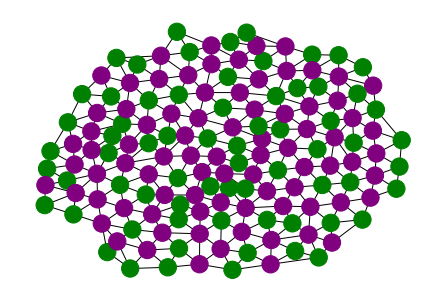

In [8]:
print("Number of organoids, max q, min q: ", len(filtered), max(ranges), min(ranges))
G = create_graph(xys[0])

nx.draw(G, pos = xys[0], node_color = fates[0], cmap = ListedColormap(["green", "purple"]))
plt.savefig("../figures/graph_example.tiff")


## Creation of datasets and loaders


In [8]:
class OrgDataset(Dataset):
  def __init__(self, **kwargs):
    self.nodes = 150
    #self.feats = 1

    super().__init__(**kwargs)
  
  def read(self):
    output = []
    for xy, fate, __range in zip(xys, fates, ranges):
      G = create_graph(xy)
      a = nx.convert_matrix.to_scipy_sparse_matrix(G)
      output.append(
            Graph(x=fate, a=a, y=np.array([__range]))
        )
    return output


In [9]:
from tensorflow.python.ops.gen_dataset_ops import dataset_cardinality
epochs = 100  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 100  # Batch size

dataset = OrgDataset()

# Train/valid/test split
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
data_tr = dataset[idx_tr]
data_va = dataset[idx_va]
data_te = dataset[idx_te]

# Data loaders
loader_tr = DisjointLoader(data_tr, batch_size = batch_size)
loader_va = DisjointLoader(data_va, batch_size = batch_size)
loader_te = DisjointLoader(data_te, batch_size = batch_size)


/tmp/ipykernel_10298/2795198958.py:12: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  a = nx.convert_matrix.to_scipy_sparse_matrix(G)
/home/jo/miniconda3/lib/python3.9/site-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (150, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")


## Model building and training

In [10]:
from spektral.layers import GCSConv
from spektral.layers import SRCPool, GlobalAttentionPool, GlobalAttnSumPool
#vorher war gscconv

def get_callbacks():
  return [
tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor = 0.2)  ]
################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(450, activation="relu")
        self.conv2 = GCSConv(150, activation="sigmoid")
        self.global_pool = GlobalAttnSumPool()
        self.dense1 = Dense(50, activation="relu")
        self.flatten1 = tf.keras.layers.Flatten()
        self.dense2 = Dense(1, activation="sigmoid")

    def call(self, inputs):
        x = inputs[0]
        a = inputs[1]
        i = inputs[2]
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        output = self.global_pool([x, i])
        output = self.dense1(output)
        output = self.flatten1(output)
        output = self.dense2(output)

        return output

model = Net()

optimizer = Adam(lr=0.005)
loss_fn = MeanSquaredError()

model.compile(optimizer, loss_fn)
model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, validation_data = loader_va.load(), validation_steps = loader_va.steps_per_epoch, verbose = 1, epochs= 100, callbacks = get_callbacks())
#model.save("Model1.2D")

Epoch 1/100


2022-11-16 14:17:05.960179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 14:17:05.960197: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 14:17:05.960211: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jos): /proc/driver/nvidia/version does not exist
2022-11-16 14:17:05.960894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jo/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarn

12/12 [==============================] - 3s 143ms/step - loss: 0.1470 - val_loss: 0.0865 - lr: 0.0050
Epoch 2/100
12/12 [==============================] - 2s 135ms/step - loss: 0.0439 - val_loss: 0.0339 - lr: 0.0050
Epoch 3/100
12/12 [==============================] - 2s 140ms/step - loss: 0.0277 - val_loss: 0.0232 - lr: 0.0050
Epoch 4/100
12/12 [==============================] - 2s 149ms/step - loss: 0.0169 - val_loss: 0.0180 - lr: 0.0050
Epoch 5/100
12/12 [==============================] - 2s 141ms/step - loss: 0.0105 - val_loss: 0.0099 - lr: 0.0050
Epoch 6/100
12/12 [==============================] - 2s 151ms/step - loss: 0.0074 - val_loss: 0.0072 - lr: 0.0050
Epoch 7/100
12/12 [==============================] - 2s 142ms/step - loss: 0.0057 - val_loss: 0.0067 - lr: 0.0050
Epoch 8/100
12/12 [==============================] - 2s 138ms/step - loss: 0.0055 - val_loss: 0.0062 - lr: 0.0050
Epoch 9/100
12/12 [==============================] - 2s 135ms/step - loss: 0.0063 - val_loss: 0.0053

KeyboardInterrupt: 

## Model testing

In [ ]:
input, target = loader_te.__next__()
preds = model.predict_on_batch(input)


In [ ]:
predictions_np = np.array([round(0.05*round(elem[0]/0.05), 2) for elem in preds]).reshape(100,1)
#model = tf.keras.load_model("Model1.2D")

def plot_er_hist(errors):
  bin = np.arange(-0.5, 0.55, 0.05)
  plt.hist(errors, bins = bin, density=False, weights=(np.zeros_like(errors) + 1. / errors.size)*100, facecolor="grey", edgecolor="black")
  plt.xticks(bin[::2])
  plt.yticks(range(0, 45, 5))
  plt.axvline(0, color='C1', linestyle='dashed', linewidth=2)
  plt.xlabel("Error of prediction")
  plt.ylabel("Frequency in %")

plot_er_hist((predictions_np - target))
print("MSE:", np.mean((target-predictions_np)**2))
plt.title("Model1.2D, MSE: " +  str(round(np.mean((target-predictions_np)**2), 4)))
plt.savefig("../figures/M1.2D_errors.png", dpi = 300)